In [1]:
import sys
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# 현재 노트북 파일의 경로를 기준으로 프로젝트 루트 경로를 계산
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))

# sys.path에 프로젝트 루트 경로가 없으면 추가
if project_root not in sys.path:
  sys.path.append(project_root)


In [2]:
from src.data.db_handler import DBHandler

db_handler = DBHandler(db_name="data_warehouse")

df_basic_info = db_handler.fetch_data(table_name="kr_stock_basic_info")
df_price_basic = db_handler.fetch_data(table_name="kr_stock_price_basic")
df_price_detail = db_handler.fetch_data(table_name="kr_stock_price_detail")
df_asking_price = db_handler.fetch_data(table_name="kr_stock_asking_price")


In [3]:
# 테이블 우선순위
priority_order = [
  'df_basic_info',
  'df_price_basic',
  'df_asking_price',
  'df_price_detail'
]

# 데이터프레임
dataframes = {
  'df_basic_info' : df_basic_info,
  'df_price_basic' : df_price_basic,
  'df_price_detail' : df_price_detail,
  'df_asking_price' : df_asking_price,
}

key_cols = ['ticker']

# 최종 병합에 사용될, 컬럼이 정리된 데이터프레임들을 저장할 딕셔너리
deduplicated_dataframes = {}
# 이미 선택된 컬럼
seen_columns = set()

# 2. 우선순위 순서대로 순회합니다.
for name in priority_order:
  df = dataframes[name]
  
  # 현재 데이터프레임에서 ticker를 제외하고 아직 보지 못한 새로운 컬럼만 선택
  cols = [col for col in df.columns if (col not in seen_columns) or (col in key_cols)]
  
  # 선택된 컬럼들로 새로운 데이터프레임을 만들어 저장
  deduplicated_dataframes[name] = df[cols]
  #print(f"[{name}]에서 고유 컬럼 {len(cols)}개를 선택했습니다. (중복 제거 : {len(df.columns.to_list())-len(cols)})")
  print(f'Select features in {name:<15} | cols : {len(cols):>2} | drop duplicated cols : {len(df.columns.to_list())-len(cols)}')

  # 'seen_columns' 세트에 방금 추가한 컬럼들을 업데이트
  seen_columns.update(cols)

# 수정된 데이터프레임을 다시 변수에 할당할 수 있습니다.
df_basic_info = deduplicated_dataframes['df_basic_info']
df_price_basic = deduplicated_dataframes['df_price_basic']
df_price_detail = deduplicated_dataframes['df_price_detail']
df_asking_price = deduplicated_dataframes['df_asking_price']

Select features in df_basic_info   | cols : 21 | drop duplicated cols : 0
Select features in df_price_basic  | cols : 68 | drop duplicated cols : 0
Select features in df_asking_price | cols : 46 | drop duplicated cols : 0
Select features in df_price_detail | cols : 14 | drop duplicated cols : 18


In [4]:
df = df_basic_info.copy()
table = 'df_basic_info'
print(f'kr_stock_static_data : merged {table:<15} | rows: {df.shape[0]}, cols: {df.shape[1]}')

for table in priority_order[1:]:
  df = pd.merge(
    df,
    deduplicated_dataframes[table],
    on='ticker',
    how='left'
  )
  print(f'kr_stock_static_data : merged {table:<15} | rows: {df.shape[0]}, cols: {df.shape[1]}')


kr_stock_static_data : merged df_basic_info   | rows: 200, cols: 21
kr_stock_static_data : merged df_price_basic  | rows: 200, cols: 88
kr_stock_static_data : merged df_asking_price | rows: 200, cols: 133
kr_stock_static_data : merged df_price_detail | rows: 200, cols: 146


In [5]:
ROW, COL = df.shape[0], df.shape[1]

df_cols = df.columns.to_list()
columns_info = pd.DataFrame(columns=df_cols)

df.head()

,ticker,lstg_stqt,cpta,papr,scts_mket_lstg_dt,idx_bztp_lcls_cd,idx_bztp_mcls_cd,idx_bztp_scls_cd,prdt_name,prdt_abrv_name,std_pdno,sbst_pric,thdt_clpr,bfdy_clpr,std_idst_clsf_cd,std_idst_clsf_cd_name,idx_bztp_lcls_cd_name,idx_bztp_mcls_cd_name,idx_bztp_scls_cd_name,issu_istt_cd,frnr_psnl_lmt_rt,iscd_stat_cls_code,marg_rate,new_hgpr_lwpr_cls_code,bstp_kor_isnm,crdt_able_yn,grmn_rate_cls_code,elw_pblc_yn,stck_prpr,prdy_vrss,prdy_vrss_sign,prdy_ctrt,acml_tr_pbmn,acml_vol,prdy_vrss_vol_rate,stck_oprc,stck_hgpr,stck_lwpr,stck_mxpr,stck_llam,stck_sdpr,wghn_avrg_stck_prc,hts_frgn_ehrt,frgn_ntby_qty,pgtr_ntby_qty,pvt_scnd_dmrs_prc,pvt_frst_dmrs_prc,pvt_pont_val,pvt_frst_dmsp_prc,pvt_scnd_dmsp_prc,dmrs_val,dmsp_val,cpfn,rstc_wdth_prc,stck_fcam,stck_sspr,aspr_unit,lstn_stcn,hts_avls,per,pbr,vol_tnrt,eps,bps,d250_hgpr,d250_hgpr_date,d250_hgpr_vrss_prpr_rate,d250_lwpr,d250_lwpr_date,d250_lwpr_vrss_prpr_rate,stck_dryy_hgpr,dryy_hgpr_vrss_prpr_rate,dryy_hgpr_date,stck_dryy_lwpr,dryy_lwpr_vrss_prpr_rate,dryy_lwpr_date,w52_hgpr,w52_hgpr_vrss_prpr_ctrt,w52_hgpr_date,w52_lwpr,w52_lwpr_vrss_prpr_ctrt,w52_lwpr_date,whol_loan_rmnd_rate,stck_shrn_iscd,fcam_cnnm,cpfn_cnnm,frgn_hldn_qty,last_ssts_cntg_qty,aspr_acpt_hour,askp1,askp2,askp3,askp4,askp5,askp6,askp7,askp8,askp9,askp10,bidp1,bidp2,bidp3,bidp4,bidp5,bidp6,bidp7,bidp8,bidp9,bidp10,askp_rsqn1,askp_rsqn2,askp_rsqn3,askp_rsqn4,askp_rsqn5,askp_rsqn6,askp_rsqn7,askp_rsqn8,askp_rsqn9,askp_rsqn10,bidp_rsqn1,bidp_rsqn2,bidp_rsqn3,bidp_rsqn4,bidp_rsqn5,bidp_rsqn6,bidp_rsqn7,bidp_rsqn8,bidp_rsqn9,bidp_rsqn10,total_askp_rsqn,total_bidp_rsqn,ntby_aspr_rsqn,new_mkop_cls_code,prdy_clpr_vrss_oprc_rate,crdt_rate,lwpr_vrss_prpr,lwpr_vrss_prpr_sign,prdy_clpr_vrss_lwpr_rate,hgpr_vrss_prpr,hgpr_vrss_prpr_sign,prdy_clpr_vrss_hgpr_rate,oprc_vrss_prpr,oprc_vrss_prpr_sign,bstp_cls_code,stck_prdy_clpr,prdy_vol
0,005930,5919637922,778046685000,100,1975-06-11,002,013,013,삼성전자보통주,삼성전자,KR7005930003,60570,79700,79700,032604,통신 및 방송 장비 제조업,시가총액규모대,"전기,전자","전기,전자",00593,0.0,55,20.0,신고가,전기·전자,True,40,True,79700,-800.0,5,-0.99,1672547819584,20898386,81.57,81100,81200,79600,104600,56400,80500,80032.73,51.11,-537726.0,938828,81766,81132,79866,79232,77966,81450,79550,7780,24100,100,61180,100,5919637922,4717951,16.10,1.38,0.35,4950.0,57930,81200,2025-09-19,-1.85,49900,2024-11-14,59.72,81200,-1.85,2025-09-19,50800,56.89,2025-02-03,81200,-1.85,2025-09-19,49900,59.72,2024-11-14,0.17,005930,100.0,"7,780 억",3025406868,489779,160000,79800,79900,80000,80100,80200,80300,80400,80500,80600,80700,79700,79600,79500,79400,79300,79200,79100,79000,78900,78800,13017,169308,419352,114908,74080,110920,114116,182638,57278,75765,76986,368213,346156,230969,113667,134434,92375,134734,37943,39241,1331382,1574718,243336,31,0.75,20.0,100.0,2,-1.12,-1500.0,5,0.87,-1400.0,5,005930,80500,25619036
1,000660,728002365,3657652050000,5000,1996-12-26,002,013,013,에스케이하이닉스보통주,SK하이닉스,KR7000660001,254160,353000,353000,032601,반도체 제조업,시가총액규모대,"전기,전자","전기,전자",00066,0.0,55,20.0,신고가,전기·전자,True,40,True,353000,NaN,3,0.00,1546050743059,4385543,96.89,351500,360000,348000,458500,247500,353000,352559.79,56.08,-982503.0,-357729,369333,361166,348833,340666,328333,365250,344750,36577,105500,5000,254160,500,728002365,2569848,12.99,3.38,0.60,27182.0,104567,360000,2025-09-19,-1.94,144700,2024-09-19,143.95,360000,-1.94,2025-09-19,162700,116.96,2025-04-09,360000,-1.94,2025-09-19,144700,143.95,2024-09-19,0.16,000660,NaN,"36,576 억",408260104,84763,160000,353000,353500,354000,354500,355000,355500,356000,356500,357000,357500,352500,352000,351500,351000,350500,350000,349500,349000,348500,348000,24717,92990,113523,93498,21597,24558,11583,9984,5897,2980,1200,7851,8441,7159,5496,17659,16585,15733,16953,23271,401327,120348,-280979,31,-0.42,20.0,5000.0,2,-1.42,-7000.0,5,1.98,1500.0,2,000660,353000,4526286
2,373220,234000000,117000000000,500,2022-01-27,None,None,None,LG에너지솔루션보통주,LG에너지솔루션,KR7373220003,265620,349500,349500,032802,일차전지 및 축전지 제조업,None,None,None,37322,0.0,55,20.0,NaN,전기·전자,True,40,Tr

In [6]:
df = df.copy()

df[df_cols] = df[df_cols].replace(r'^\s*$', np.nan, regex=True)
df[df_cols] = df[df_cols].replace(['0', 0], np.nan)

In [7]:
# 결측값 개수/비율 산출 및 제거 리스트
missing_count = df[df_cols].isnull().sum()
missing_percent = ((missing_count / ROW) * 100).round(2)

# --- 3. 결과 취합 및 출력 ---
missing_df = pd.DataFrame({
  'missing_count': missing_count,
  'missing_percent': missing_percent
})

columns_info.loc['missing_count'] = missing_df['missing_count']
columns_info.loc['missing_percent'] = missing_df['missing_percent']

columns_info

,ticker,lstg_stqt,cpta,papr,scts_mket_lstg_dt,idx_bztp_lcls_cd,idx_bztp_mcls_cd,idx_bztp_scls_cd,prdt_name,prdt_abrv_name,std_pdno,sbst_pric,thdt_clpr,bfdy_clpr,std_idst_clsf_cd,std_idst_clsf_cd_name,idx_bztp_lcls_cd_name,idx_bztp_mcls_cd_name,idx_bztp_scls_cd_name,issu_istt_cd,frnr_psnl_lmt_rt,iscd_stat_cls_code,marg_rate,new_hgpr_lwpr_cls_code,bstp_kor_isnm,crdt_able_yn,grmn_rate_cls_code,elw_pblc_yn,stck_prpr,prdy_vrss,prdy_vrss_sign,prdy_ctrt,acml_tr_pbmn,acml_vol,prdy_vrss_vol_rate,stck_oprc,stck_hgpr,stck_lwpr,stck_mxpr,stck_llam,stck_sdpr,wghn_avrg_stck_prc,hts_frgn_ehrt,frgn_ntby_qty,pgtr_ntby_qty,pvt_scnd_dmrs_prc,pvt_frst_dmrs_prc,pvt_pont_val,pvt_frst_dmsp_prc,pvt_scnd_dmsp_prc,dmrs_val,dmsp_val,cpfn,rstc_wdth_prc,stck_fcam,stck_sspr,aspr_unit,lstn_stcn,hts_avls,per,pbr,vol_tnrt,eps,bps,d250_hgpr,d250_hgpr_date,d250_hgpr_vrss_prpr_rate,d250_lwpr,d250_lwpr_date,d250_lwpr_vrss_prpr_rate,stck_dryy_hgpr,dryy_hgpr_vrss_prpr_rate,dryy_hgpr_date,stck_dryy_lwpr,dryy_lwpr_vrss_prpr_rate,dryy_lwpr_date,w52_hgpr,w52_hgpr_vrss_prpr_ctrt,w52_hgpr_date,w52_lwpr,w52_lwpr_vrss_prpr_ctrt,w52_lwpr_date,whol_loan_rmnd_rate,stck_shrn_iscd,fcam_cnnm,cpfn_cnnm,frgn_hldn_qty,last_ssts_cntg_qty,aspr_acpt_hour,askp1,askp2,askp3,askp4,askp5,askp6,askp7,askp8,askp9,askp10,bidp1,bidp2,bidp3,bidp4,bidp5,bidp6,bidp7,bidp8,bidp9,bidp10,askp_rsqn1,askp_rsqn2,askp_rsqn3,askp_rsqn4,askp_rsqn5,askp_rsqn6,askp_rsqn7,askp_rsqn8,askp_rsqn9,askp_rsqn10,bidp_rsqn1,bidp_rsqn2,bidp_rsqn3,bidp_rsqn4,bidp_rsqn5,bidp_rsqn6,bidp_rsqn7,bidp_rsqn8,bidp_rsqn9,bidp_rsqn10,total_askp_rsqn,total_bidp_rsqn,ntby_aspr_rsqn,new_mkop_cls_code,prdy_clpr_vrss_oprc_rate,crdt_rate,lwpr_vrss_prpr,lwpr_vrss_prpr_sign,prdy_clpr_vrss_lwpr_rate,hgpr_vrss_prpr,hgpr_vrss_prpr_sign,prdy_clpr_vrss_hgpr_rate,oprc_vrss_prpr,oprc_vrss_prpr_sign,bstp_cls_code,stck_prdy_clpr,prdy_vol
missing_count,0.0,0.0,0.0,0.0,0.0,49.0,62.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,68.0,74.0,0.0,198.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,21.0,0.0,6.0,20.0,0.0,22.0,10.0,0.0,0.0,0.0,0.0
missing_percent,0.0,0.0,0.0,0.0,0.0,24.5,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,34.0,37.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,10.5,0.0,3.0,10.0,0.0,11.0,5.0,0.0,0.0,0.0,0.0


In [8]:
# 중복값 개수/비율 산출 및 제거 리스트 설정
unique_count = df[df_cols].nunique()
unique_percent = ((unique_count / ROW) * 100).round(2)

# --- 3. 결과 취합 및 출력 ---
unique_df = pd.DataFrame({
  'unique_count': unique_count,
  'unique_percent': unique_percent
})

columns_info.loc['unique_count'] = unique_df['unique_count']
columns_info.loc['unique_percent'] = unique_df['unique_percent']

columns_info

,ticker,lstg_stqt,cpta,papr,scts_mket_lstg_dt,idx_bztp_lcls_cd,idx_bztp_mcls_cd,idx_bztp_scls_cd,prdt_name,prdt_abrv_name,std_pdno,sbst_pric,thdt_clpr,bfdy_clpr,std_idst_clsf_cd,std_idst_clsf_cd_name,idx_bztp_lcls_cd_name,idx_bztp_mcls_cd_name,idx_bztp_scls_cd_name,issu_istt_cd,frnr_psnl_lmt_rt,iscd_stat_cls_code,marg_rate,new_hgpr_lwpr_cls_code,bstp_kor_isnm,crdt_able_yn,grmn_rate_cls_code,elw_pblc_yn,stck_prpr,prdy_vrss,prdy_vrss_sign,prdy_ctrt,acml_tr_pbmn,acml_vol,prdy_vrss_vol_rate,stck_oprc,stck_hgpr,stck_lwpr,stck_mxpr,stck_llam,stck_sdpr,wghn_avrg_stck_prc,hts_frgn_ehrt,frgn_ntby_qty,pgtr_ntby_qty,pvt_scnd_dmrs_prc,pvt_frst_dmrs_prc,pvt_pont_val,pvt_frst_dmsp_prc,pvt_scnd_dmsp_prc,dmrs_val,dmsp_val,cpfn,rstc_wdth_prc,stck_fcam,stck_sspr,aspr_unit,lstn_stcn,hts_avls,per,pbr,vol_tnrt,eps,bps,d250_hgpr,d250_hgpr_date,d250_hgpr_vrss_prpr_rate,d250_lwpr,d250_lwpr_date,d250_lwpr_vrss_prpr_rate,stck_dryy_hgpr,dryy_hgpr_vrss_prpr_rate,dryy_hgpr_date,stck_dryy_lwpr,dryy_lwpr_vrss_prpr_rate,dryy_lwpr_date,w52_hgpr,w52_hgpr_vrss_prpr_ctrt,w52_hgpr_date,w52_lwpr,w52_lwpr_vrss_prpr_ctrt,w52_lwpr_date,whol_loan_rmnd_rate,stck_shrn_iscd,fcam_cnnm,cpfn_cnnm,frgn_hldn_qty,last_ssts_cntg_qty,aspr_acpt_hour,askp1,askp2,askp3,askp4,askp5,askp6,askp7,askp8,askp9,askp10,bidp1,bidp2,bidp3,bidp4,bidp5,bidp6,bidp7,bidp8,bidp9,bidp10,askp_rsqn1,askp_rsqn2,askp_rsqn3,askp_rsqn4,askp_rsqn5,askp_rsqn6,askp_rsqn7,askp_rsqn8,askp_rsqn9,askp_rsqn10,bidp_rsqn1,bidp_rsqn2,bidp_rsqn3,bidp_rsqn4,bidp_rsqn5,bidp_rsqn6,bidp_rsqn7,bidp_rsqn8,bidp_rsqn9,bidp_rsqn10,total_askp_rsqn,total_bidp_rsqn,ntby_aspr_rsqn,new_mkop_cls_code,prdy_clpr_vrss_oprc_rate,crdt_rate,lwpr_vrss_prpr,lwpr_vrss_prpr_sign,prdy_clpr_vrss_lwpr_rate,hgpr_vrss_prpr,hgpr_vrss_prpr_sign,prdy_clpr_vrss_hgpr_rate,oprc_vrss_prpr,oprc_vrss_prpr_sign,bstp_cls_code,stck_prdy_clpr,prdy_vol
missing_count,0.0,0.0,0.0,0.0,0.0,49.0,62.0,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,68.0,74.0,0.0,198.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,21.0,0.0,6.0,20.0,0.0,22.0,10.0,0.0,0.0,0.0,0.0
missing_percent,0.0,0.0,0.0,0.0,0.0,24.5,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,34.0,37.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,10.5,0.0,3.0,10.0,0.0,11.0,5.0,0.0,0.0,0.0,0.0
unique_count,200.0,200.0,200.0,6.0,187.0,5.0,26.0,29.0,200.0,200.0,200.0,199.0,190.0,190.0,67.0,67.0,4.0,21.0,18.0,200.0,2.0,2.0,6.0,2.0,21.0,1.0,3.0,1.0,190.0,108.0,3.0,165.0,200.0,200.0,200.0,187.0,197.0,190.0,195.0,191.0,195.0,200.0,197.0,199.0,200.0,198.0,199.0,198.0,199.0,196.0,196.0,196.0,196.0,178.0,6.0,198.0,6.0,200.0,200.0,197.0,141.0,91.0,200.0,200.0,191.0,98.0,193.0,192.0,54.0,198.0,190.0,189.0,93.0,192.0,197.0,42.0,190.0,195.0,95.0,192.0,197.0,54.0,121.0,200.0,3.0,193.0,200.0,199.0,2.0,192.0,192.0,191.0,192.0,192.0,192.0,192.0,192.0,192.0,193.0,193.0,193.0,192.0,191.0,193.0,193.0,193.0,193.0,193.0,193.0,190.0,191.0,190.0,189.0,193.0,189.0,180.0,187.0,182.0,184.0,184.0,181.0,193.0,190.0,194.0,196.0,194.0,195.0,195.0,190.0,200.0,200.0,200.0,2.0,126.0,6.0,75.0,2.0,159.0,76.0,2.0,141.0,110.0,3.0,200.0,195.0,200.0
unique_percent,100.0,100.0,100.0,3.0,93.5,2.5,13.0,14.5,100.0,100.0,100.0,99.5,95.0,95.0

In [9]:
MISSING_PERCENT_THRESHOLD = 50.0
UNIQUE_COUNT_THRESHOLD = 1

# --- 2. Identify Columns to Drop ---
missing_info = columns_info.loc['missing_percent']
unique_info = columns_info.loc['unique_count']

# 제거할 컬럼과 그 이유(값)를 함께 저장
drop_missing_cols = {
  col: val for col, val in missing_info.items() 
  if val > MISSING_PERCENT_THRESHOLD
}
drop_unique_cols = {
  col: val for col, val in unique_info.items() 
  if val <= UNIQUE_COUNT_THRESHOLD
}

# 최종 제거 목록 생성
total_drop_cols = sorted(list(set(drop_missing_cols.keys()) | set(drop_unique_cols.keys())))

# --- 3. Logging and Execution ---
print("="*80)
print("Step: Feature Selection based on Data Quality".center(80))
print("="*80)

# [INFO] Initial DataFrame shape: 출력
left_str = "[INFO] Initial DataFrame shape:"
right_str = str(df.shape)
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

# [INFO] Thresholds: 출력 (사용자 요청 최종 포맷 적용)
left_str = "[INFO] Thresholds"
# --- Missing % 라인 ---
right_str = f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%"
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

# --- Unique Count 라인 ---
right_str = f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}"
padding = 80 - len(right_str)
print(f"{left_str:<{padding}}{right_str}")

print("-"*80)


if total_drop_cols:
  df_cleaned = df.drop(columns=total_drop_cols)
  
  print("[ACTION] Dropping columns...")
  
  if drop_missing_cols:
    header_text = f" Reason: High Missing Value Ratio ({len(drop_missing_cols)} columns) "
    print(f"\n{header_text.center(80, '-')}")
    for col, val in drop_missing_cols.items():
      left_str = f"- Dropping {col}"
      right_str = f"(Missing: {val:.2f}%)"
      padding = 80 - len(right_str)
      print(f"{left_str:<{padding}}{right_str}")
          
  if drop_unique_cols:
    header_text = f" Reason: Low Unique Value Count ({len(drop_unique_cols)} columns) "
    print(f"\n{header_text.center(80, '-')}")
    for col, val in drop_unique_cols.items():
      left_str = f"- Dropping {col}"
      right_str = f"(Unique Count: {int(val)})"
      padding = 80 - len(right_str)
      print(f"{left_str:<{padding}}{right_str}")

  print("\n" + "-"*80)
  print(f"[SUMMARY] Total {len(total_drop_cols)} columns dropped.")
  print(f"[SUMMARY] Cleaned DataFrame shape: {df_cleaned.shape}")

else:
  df_cleaned = df.copy()
  print("[SUMMARY] No columns to drop. DataFrame remains unchanged.")

print("="*80)


                 Step: Feature Selection based on Data Quality                  
[INFO] Initial DataFrame shape:                                       (200, 146)
[INFO] Thresholds                                        Missing Percent > 50.0%
[INFO] Thresholds                                           Unique Count <=    1
--------------------------------------------------------------------------------
[ACTION] Dropping columns...

----------------- Reason: High Missing Value Ratio (2 columns) -----------------
- Dropping frnr_psnl_lmt_rt                                    (Missing: 99.00%)
- Dropping fcam_cnnm                                           (Missing: 63.00%)

------------------ Reason: Low Unique Value Count (2 columns) ------------------
- Dropping crdt_able_yn                                        (Unique Count: 1)
- Dropping elw_pblc_yn                                         (Unique Count: 1)

-----------------------------------------------------------------------------

In [10]:
import pandas as pd
import numpy as np

# 1. 수치형 컬럼 선택
cleaned_numeric_cols = df_cleaned.select_dtypes(include=np.number).columns.tolist()

# 2. 범주형 컬럼 선택
cleaned_categorical_cols = df_cleaned.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

# 3. Datetime 컬럼 선택 (누락되었던 부분)
cleaned_datetime_cols = df_cleaned.select_dtypes(include=['datetime64[ns]']).columns.tolist()

# Ticker는 식별자이므로 분석 리스트에서 제외
# (이미 수행하셨지만, 안전을 위해 한 번 더 확인)
if 'ticker' in cleaned_categorical_cols:
  cleaned_categorical_cols.remove('ticker') # ticker는 보통 category 타입

# --- 결과 확인 ---
print(f"총 {len(df_cleaned.columns)}개의 컬럼이 3개의 그룹으로 분리되었습니다.")
print("-" * 50)
print(f"수치형 컬럼 ({len(cleaned_numeric_cols)}개)")
print(f"범주형 컬럼 ({len(cleaned_categorical_cols)}개)")
print(f"Datetime 컬럼 ({len(cleaned_datetime_cols)}개)")
print("-" * 50)

# 최종 검증
total_classified = len(cleaned_numeric_cols) + len(cleaned_categorical_cols) + len(cleaned_datetime_cols)
print(f"검증: {total_classified + 1} (분류된 컬럼) == {len(df_cleaned.columns)} (전체 컬럼)")

총 142개의 컬럼이 3개의 그룹으로 분리되었습니다.
--------------------------------------------------
수치형 컬럼 (110개)
범주형 컬럼 (24개)
Datetime 컬럼 (7개)
--------------------------------------------------
검증: 142 (분류된 컬럼) == 142 (전체 컬럼)


✅ 총 878개의 변수 쌍에서 임계값(0.95)을 초과하는 높은 상관관계가 발견되었습니다.
👉 상관관계가 높은 변수 개수: 61개
👉 상관관계가 낮은 변수 개수: 49개


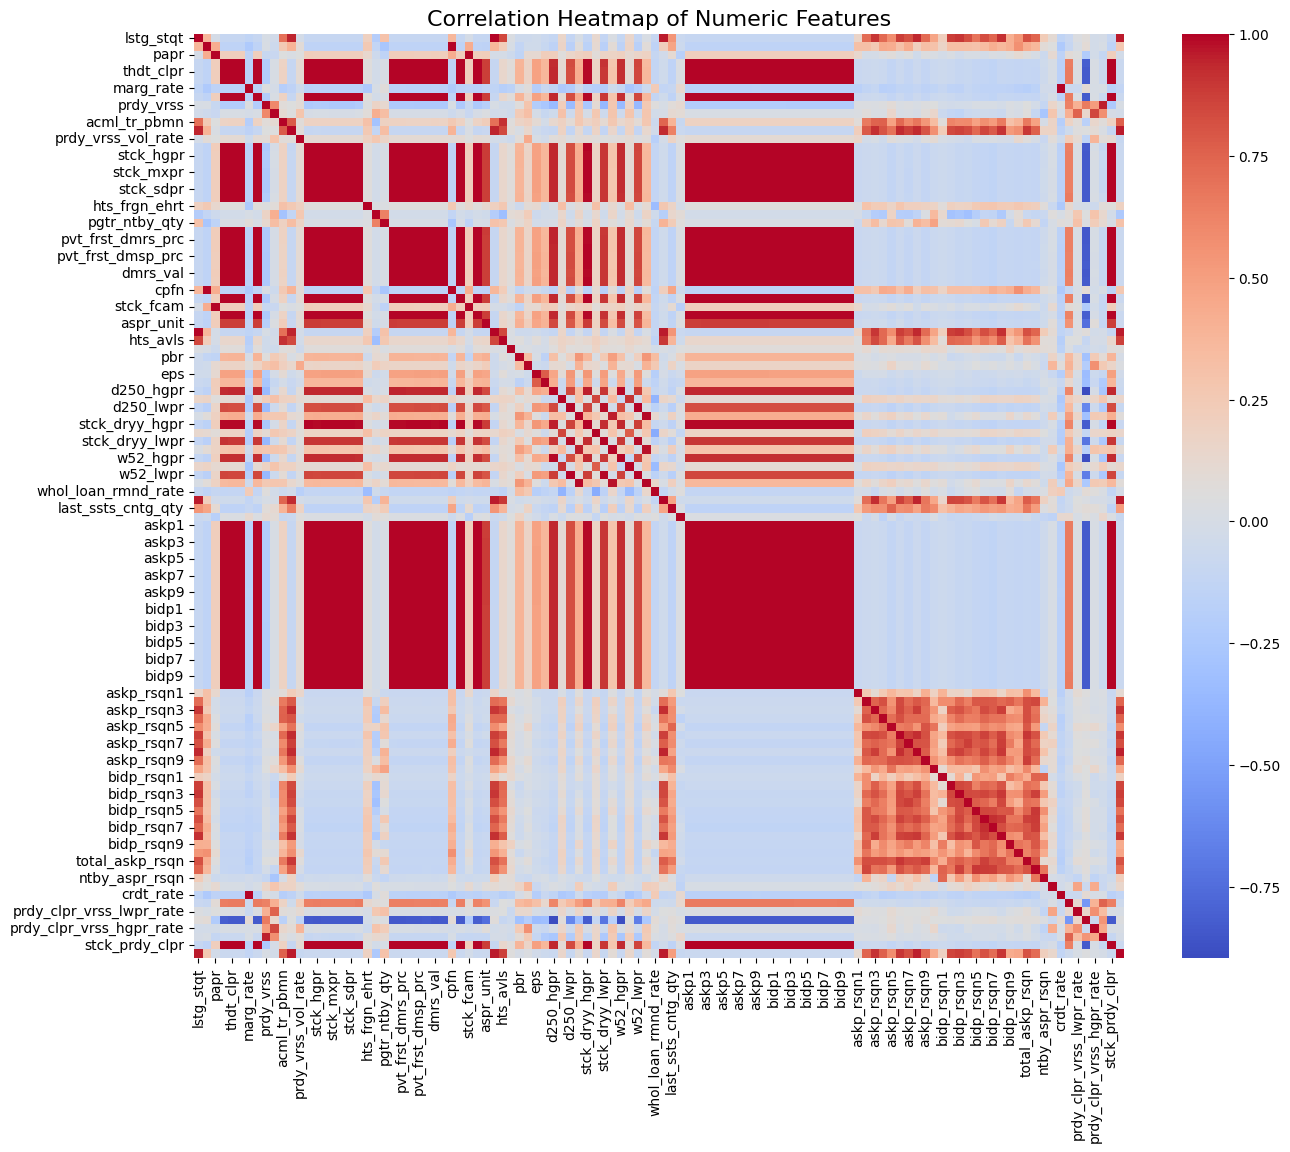

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: 상관관계 행렬 계산 ---
numeric_df = df_cleaned[cleaned_numeric_cols]
corr_matrix = numeric_df.corr(method='pearson')

# --- Step 2: 높은 상관관계를 가진 변수 쌍 자동 추출 ---
THRESHHOLD = 0.95
num_high_corr_pairs = []

# 중복을 피하기 위해 상관 행렬의 상삼각행렬(upper triangle)만 순회
for i in range(len(corr_matrix.columns)):
  for j in range(i):
    if abs(corr_matrix.iloc[i, j]) > THRESHHOLD:
      pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
      num_high_corr_pairs.append(pair)

# 상관계수가 높은 순으로 정렬
num_high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"✅ 총 {len(num_high_corr_pairs)}개의 변수 쌍에서 임계값({THRESHHOLD})을 초과하는 높은 상관관계가 발견되었습니다.")

# --- Step 3: 상관관계가 높은 변수와 낮은 변수 리스트 분리 ---

# 상관관계가 높은 변수들의 이름만 추출 (중복 제거를 위해 set 사용)
# num_high_corr_pairs 리스트를 순회하며 각 튜플의 첫 번째, 두 번째 원소(변수 이름)를 모두 가져옵니다.
high_corr_cols_set = set()
for pair in num_high_corr_pairs:
  high_corr_cols_set.add(pair[0])
  high_corr_cols_set.add(pair[1])

high_corr_cols = list(high_corr_cols_set) # 최종 리스트로 변환

# 전체 숫자형 변수 중, high_corr_cols에 포함되지 않은 변수들만 선택
# 이 변수들은 다른 변수와 상관관계가 높지 않아 그대로 사용해도 좋은 후보들입니다.
low_corr_cols = [col for col in cleaned_numeric_cols if col not in high_corr_cols]

# [결과 확인]
print(f"👉 상관관계가 높은 변수 개수: {len(high_corr_cols)}개")
print(f"👉 상관관계가 낮은 변수 개수: {len(low_corr_cols)}개")


# --- Step 4: 히트맵 시각화 (전체적인 분포 확인용) ---
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.show()

✅ 총 8개의 상관관계 그룹을 자동으로 찾았습니다.
--------------------------------------------------


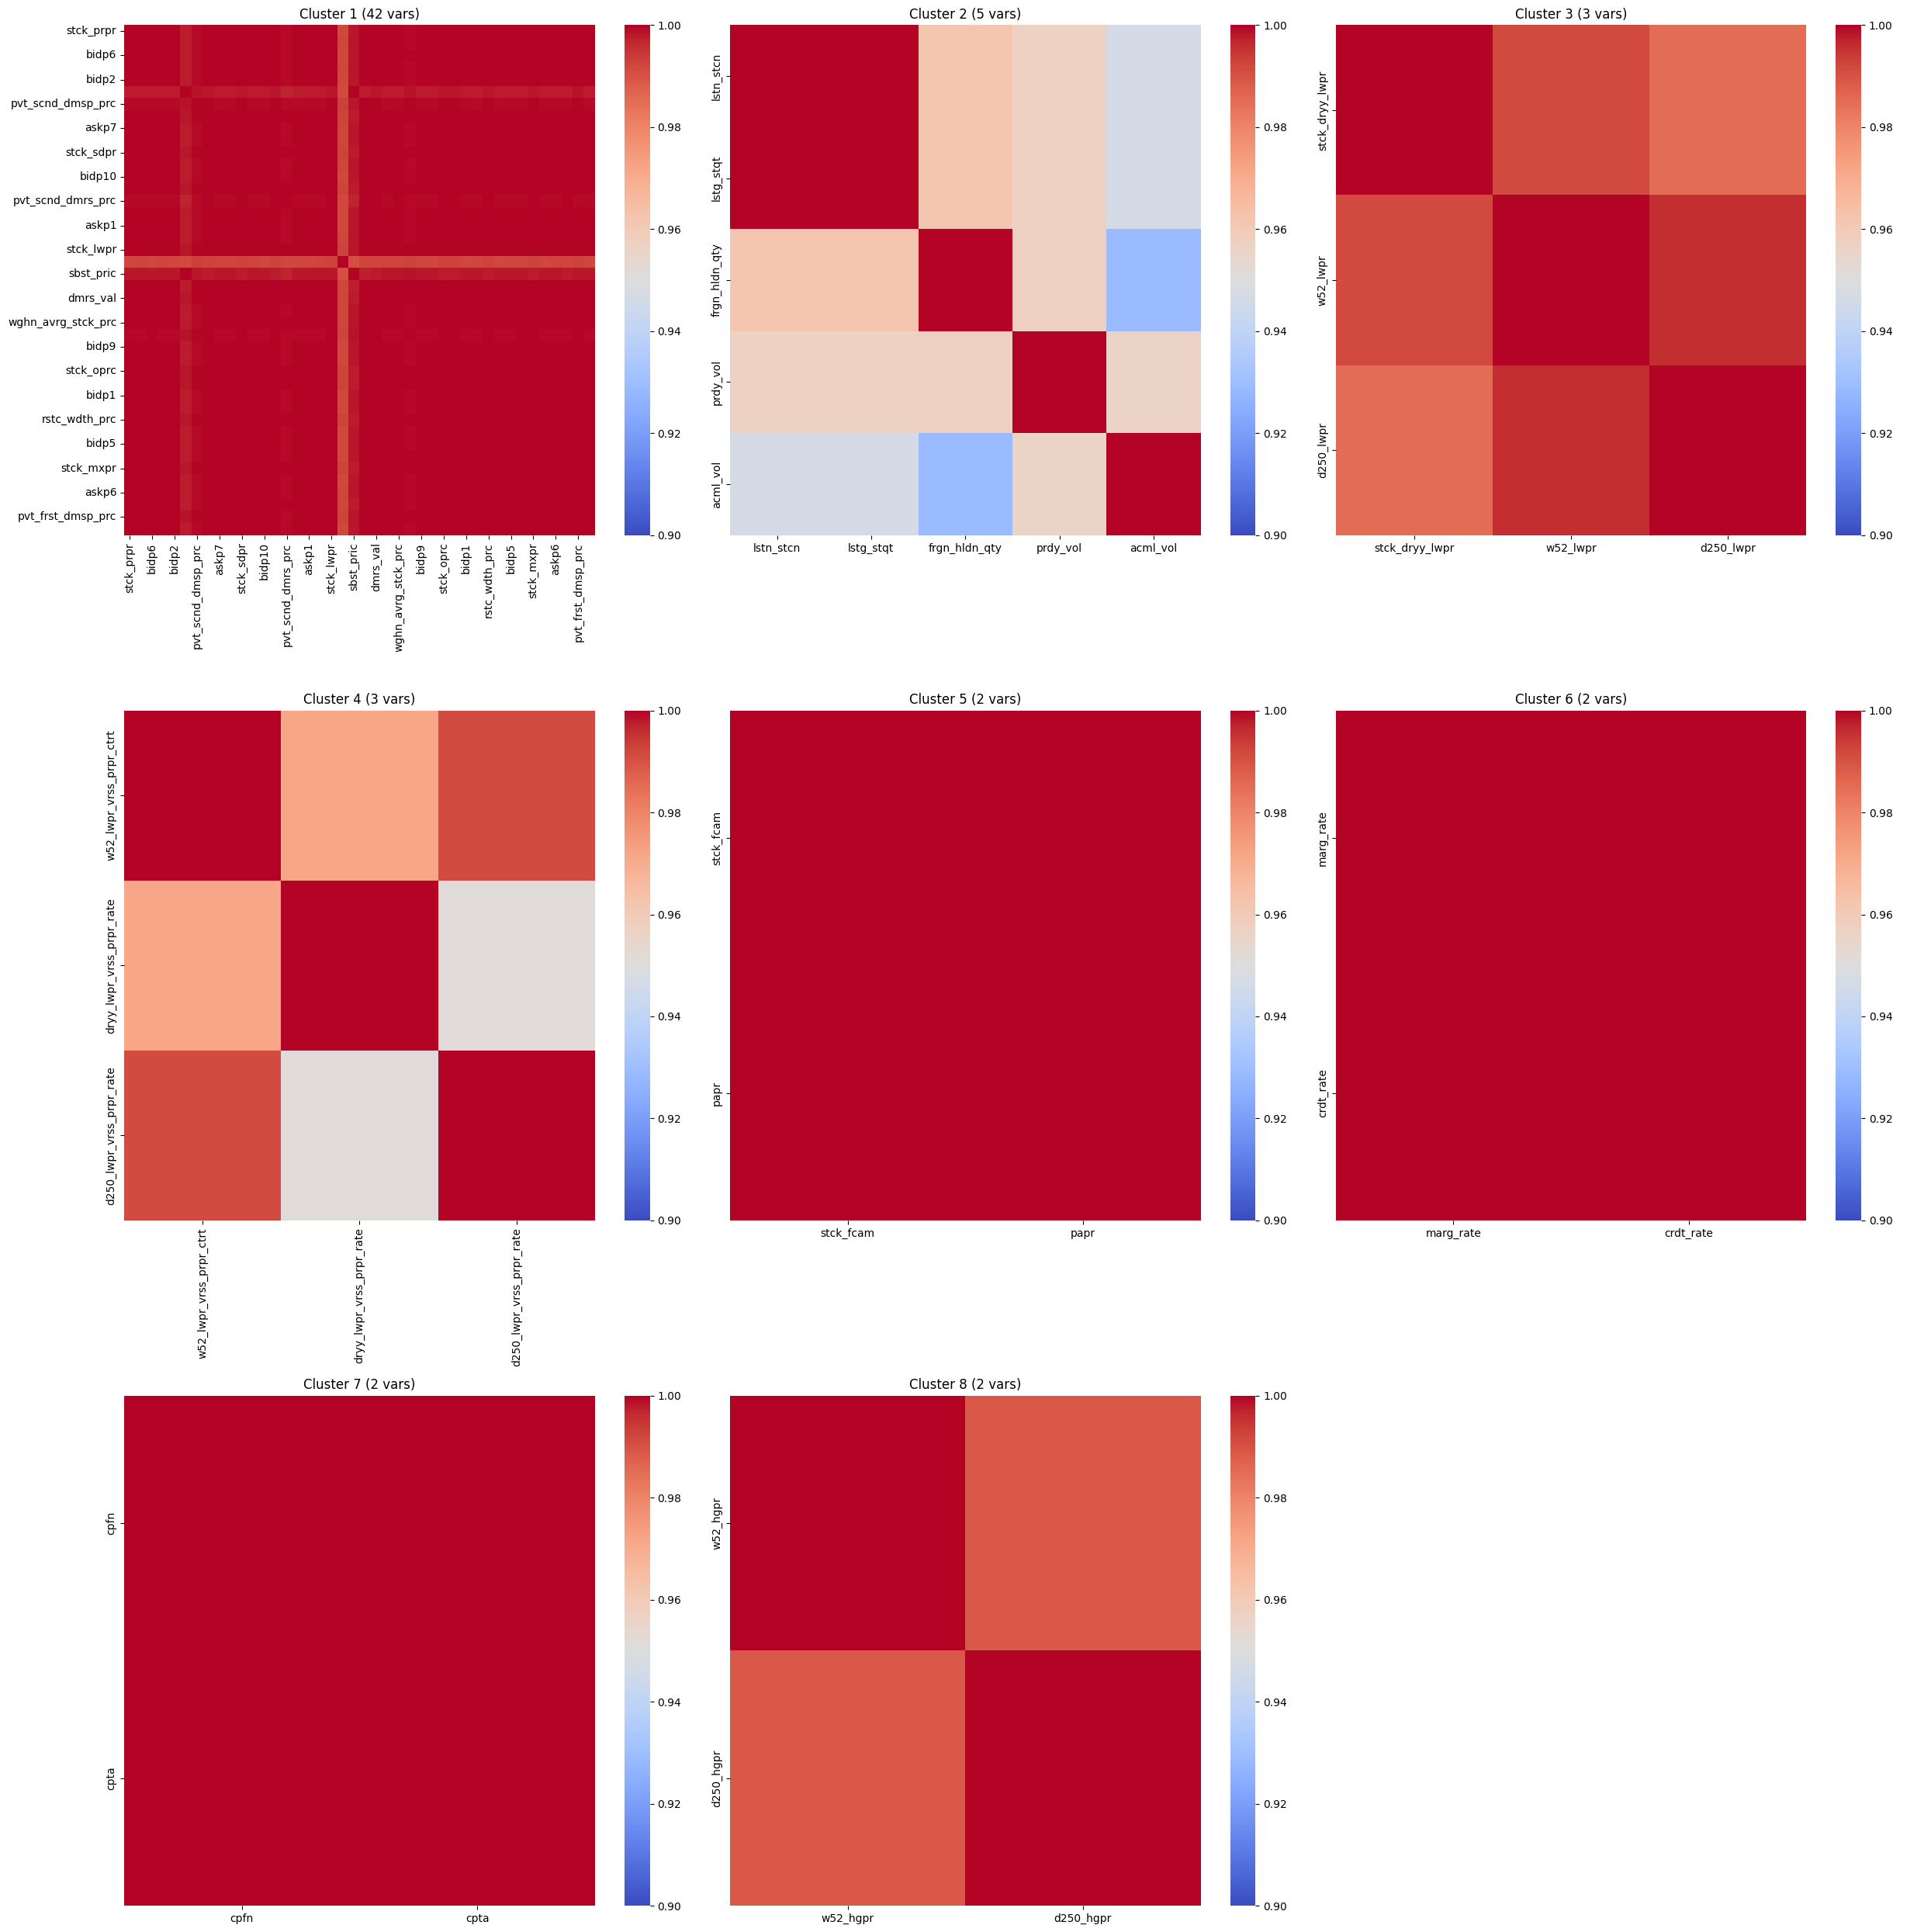

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

# --- 기존 그룹핑 코드 ---
G = nx.Graph()
edges = [(pair[0], pair[1]) for pair in num_high_corr_pairs]
G.add_edges_from(edges)
clusters = list(nx.connected_components(G))

print(f"✅ 총 {len(clusters)}개의 상관관계 그룹을 자동으로 찾았습니다.")
print("-" * 50)

# 1. 3x3 그리드(subplot)를 생성합니다. 전체 이미지 크기를 크게 설정합니다.
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(25, 25))

# 2. axes 배열을 1차원으로 펼쳐서 다루기 쉽게 만듭니다.
ax_flat = axes.flatten()

# 3. 클러스터를 크기 순으로 정렬합니다.
sorted_clusters = sorted(clusters, key=len, reverse=True)

# 4. 각 클러스터에 대해 루프를 실행하며 순서대로 subplot에 히트맵을 그립니다.
for i, cluster_vars in enumerate(sorted_clusters):
  ax = ax_flat[i] # 현재 그릴 subplot 위치 선택
  
  if len(cluster_vars) > 1:
    cluster_df = numeric_df[list(cluster_vars)]
    cluster_corr_matrix = cluster_df.corr()
    
    # cmap='coolwarm'으로 색상 변경, ax=ax로 위치 지정
    sns.heatmap(cluster_corr_matrix, cmap='coolwarm', ax=ax, vmin=0.9, vmax=1.0)
    ax.set_title(f'Cluster {i+1} ({len(cluster_vars)} vars)')
  else:
    # 변수가 하나뿐인 클러스터는 비워둡니다.
    ax.axis('off')

# 5. 만약 클러스터 개수가 12개보다 적을 경우, 남는 subplot 공간을 숨깁니다.
for i in range(len(sorted_clusters), len(ax_flat)):
  ax_flat[i].axis('off')

# 6. 그래프들이 겹치지 않도록 레이아웃을 자동 조정합니다.
plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

print("\n\n" + "="*80)
print("각 그룹별 평균 상관계수 분석 (대표 변수 선정을 위한 최종 분석)")
print("="*80)

# --- 각 그룹별 평균 상관계수 계산 및 출력 로직 ---
for i, cluster_vars in enumerate(sorted_clusters):
  cluster_num = i + 1
  
  if len(cluster_vars) > 1:
    # 1. 전체 상관관계 행렬에서 현재 클러스터에 해당하는 부분만 선택
    cluster_corr = corr_matrix.loc[list(cluster_vars), list(cluster_vars)]
    
    # 2. 각 변수별로 다른 변수들과의 평균 상관계수(절댓값 기준)를 계산
    #    .abs()를 통해 양/음의 방향성 없이 관계의 강도만으로 계산
    avg_corr = cluster_corr.abs().mean().sort_values(ascending=False)
    
    # 3. 결과 출력
    header_text = f" Cluster {cluster_num} ({len(cluster_vars)} vars) Average Correlation "
    print(f"\n{header_text.center(80, '-')}")
    print(avg_corr)



각 그룹별 평균 상관계수 분석 (대표 변수 선정을 위한 최종 분석)

------------------- Cluster 1 (42 vars) Average Correlation --------------------
wghn_avrg_stck_prc    0.999628
stck_lwpr             0.999627
bidp4                 0.999621
bidp5                 0.999621
bidp6                 0.999620
bidp7                 0.999619
bidp3                 0.999617
bidp8                 0.999616
bidp9                 0.999615
bidp2                 0.999611
bidp1                 0.999611
bidp10                0.999610
askp3                 0.999609
askp4                 0.999609
askp5                 0.999608
askp2                 0.999607
askp6                 0.999606
askp7                 0.999605
askp8                 0.999604
askp9                 0.999602
askp1                 0.999597
bfdy_clpr             0.999596
stck_prpr             0.999596
thdt_clpr             0.999596
askp10                0.999596
stck_hgpr             0.999581
stck_llam             0.999564
stck_sdpr             0.999564
stck_prdy_

### 그룹 1: 가격(Price) 핵심 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| **(일일 핵심 가격)** | | | |
| `thdt_clpr` | 당일 종가 | **선정** | 하루의 가격을 대표하는 가장 표준적인 지표. |
| `bfdy_clpr` | 전일 종가 | **선정** | 당일 등락률 계산의 기준이 되는 핵심 정보. |
| `stck_oprc` | 당일 시가 | **선정** | 장 시작 가격으로, 하루의 추세를 분석하는 데 필수적. |
| `stck_hgpr` | 당일 고가 | **선정** | 당일 변동성의 상단을 나타내는 핵심 정보. |
| `stck_lwpr` | 당일 저가 | **선정** | 당일 변동성의 하단을 나타내는 핵심 정보. |
| `wghn_avrg_stck_prc`| 가중평균주가(VWAP) | **선정** | 거래량을 반영한 실질적인 평균 체결가로, 고유한 정보를 제공. |
| `stck_prpr` | 현재가 | 제거 | `thdt_clpr`(종가)와 정보가 완전히 동일. (대체 가능: `thdt_clpr`) |
| **(가격 제한폭/기준가)** | | | |
| `stck_mxpr` | 당일 상한가 | **선정** | 가격 변동의 상단 경계. |
| `stck_llam` | 당일 하한가 | **선정** | 가격 변동의 하단 경계. |
| `stck_sdpr` | 당일 기준가 | **선정** | 가격제한폭 계산의 기준이 되는 가격. |
| `stck_sspr` | 대용가 | **선정** | 증거금으로 사용될 때의 가격으로, 시장 제도와 관련된 고유 정보. |
| `sbst_pric` | 기준가 | **선정** | 주식의 가치를 평가하는 또 다른 기준 가격으로 고유 정보를 가질 수 있음. |
| `rstc_wdth_prc` | 가격제한폭 | 제거 | `stck_mxpr`(상한가)와 `stck_llam`(하한가)로 계산 가능한 정보. |
| `stck_prdy_clpr` | 전일 종가 | 제거 | `bfdy_clpr`와 정보가 완전히 동일. (대체 가능: `bfdy_clpr`) |
| **(매도 호가)** | | | |
| `askp1` | 최우선 매도호가 | **선정** | 매도-매수 스프레드를 파악하고 실질적인 매도 압력을 분석하는 핵심 지표. |
| `askp10` | 10순위 매도호가 | **선정** | 호가창의 깊이를 대략적으로 파악할 수 있는 지표. |
| `askp2` ~ `askp9` | 2~9순위 매도호가 | 제거 | `askp1` 및 `askp10`과 상관관계가 극도로 높으며, `askp1`과 `askp10`으로 핵심 정보를 대표할 수 있음. |
| **(매수 호가)** | | | |
| `bidp1` | 최우선 매수호가 | **선정** | 매도-매수 스프레드를 파악하고 실질적인 매수 압력을 분석하는 핵심 지표. |
| `bidp10` | 10순위 매수호가 | **선정** | 호가창의 깊이를 대략적으로 파악할 수 있는 지표. |
| `bidp2` ~ `bidp9` | 2~9순위 매수호가 | 제거 | `bidp1` 및 `bidp10`과 상관관계가 극도로 높으며, `bidp1`과 `bidp10`으로 핵심 정보를 대표할 수 있음. |
| **(기술적 지표)** | | | |
| `pvt_pont_val` | 피봇 기준선 | **선정** | 피봇 분석의 중심이 되는 기준선. |
| `pvt_frst_dmrs_prc` | 피봇 1차 저항선 | **선정** | 피봇 기반의 주요 저항 레벨. |
| `pvt_scnd_dmrs_prc` | 피봇 2차 저항선 | **선정** | 피봇 기반의 주요 저항 레벨. |
| `pvt_frst_dmsp_prc` | 피봇 1차 지지선 | **선정** | 피봇 기반의 주요 지지 레벨. |
| `pvt_scnd_dmsp_prc` | 피봇 2차 지지선 | **선정** | 피봇 기반의 주요 지지 레벨. |
| `dmrs_val` | 디마크 고가(저항) | **선정** | 피봇과는 다른 방식으로 계산된 기술적 저항선. |
| `dmsp_val` | 디마크 저가(지지) | **선정** | 피봇과는 다른 방식으로 계산된 기술적 지지선. |
| **(역사적 고점)** | | | |
| `stck_dryy_hgpr` | 연중 최고가 | **선정** | 연초 대비 모멘텀을 분석하기 위한 고유한 기간의 최고가 정보. |

---
### 그룹 2: 수량(Quantity) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `lstg_stqt` | 상장주식수 | **선정** | 기업의 규모와 유통 주식 수를 나타내는 핵심 펀더멘털 지표. |
| `lstn_stcn` | 상장주식수 (중복) | 제거 | `lstg_stqt`와 정보가 완전히 동일함. (대체 가능: `lstg_stqt`) |
| `acml_vol` | 누적 거래량 | **선정** | 당일 시장의 관심도와 활동성을 나타내는 가장 중요한 지표. |
| `prdy_vol` | 전일 거래량 | **선정** | 당일 거래량과의 비교를 통해 거래량의 급증/급감을 파악하는 데 필요한 고유 정보. |
| `frgn_hldn_qty`| 외국인 보유수량 | **선정** | 수급 주체를 파악하는 핵심 지표로, 다른 수량 지표와는 다른 고유한 정보를 제공. |

---
### 그룹 3: 역사적 저점(Historical Lows) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `w52_lwpr` | 52주 최저가 | **선정** | 약 1년간의 장기적인 관점에서 주가의 하단 지지 레벨을 분석하는 핵심 지표. |
| `d250_lwpr` | 250일 최저가 | **선정** | 거래일 기준(약 1년)의 최저가로, `w52_lwpr`과 미세하게 다른 기간의 정보를 제공하여 분석 가치가 있음. |
| `stck_dryy_lwpr`| 연중 최저가 | **선정** | 해당 연도(Year-to-Date) 기준의 최저가로, 기간 설정이 다른 고유한 모멘텀 정보. |

---
### 그룹 4: 역사적 저점 대비 등락률 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `w52_lwpr_vrss_prpr_ctrt` | 52주 최저가 대비 등락률 | **선정** | 장기 저점으로부터의 회복률을 나타내는 표준적인 모멘텀 지표. |
| `d250_lwpr_vrss_prpr_rate`| 250일 최저가 대비 등락률 | **선정** | 거래일 기준 저점에서의 회복률로, `w52_lwpr` 기반 지표와 비교 분석할 가치가 있음. |
| `dryy_lwpr_vrss_prpr_rate`| 연중 최저가 대비 등락률 | **선정** | 연초 대비 성과를 측정하는 고유한 관점의 지표. |

---
### 그룹 5: 액면가(Par Value) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `papr` | 액면가 | **선정** | 주식의 액면 가격 정보. |
| `stck_fcam` | 액면가 (중복) | 제거 | `papr`과 정보가 완전히 동일함. (대체 가능: `papr`) |

---
### 그룹 6: 증거금률(Margin Rate) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `marg_rate` | 증거금률 | **선정** | 신용거래 가능 여부와 레버리지 수준을 나타내는 시장 제도 관련 지표. |
| `crdt_rate` | 신용비율 | 제거 | `marg_rate`와 동일한 정보를 나타냄. (대체 가능: `marg_rate`) |

---
### 그룹 7: 자본금(Capital) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `cpta` | 자본금 | **선정** | 기업의 자본 규모를 나타내는 펀더멘털 지표. |
| `cpfn` | 자본금 (중복) | 제거 | `cpta`와 정보가 완전히 동일함. (대체 가능: `cpta`) |

---
### 그룹 8: 역사적 고점(Historical Highs) 그룹 분석
| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `w52_hgpr` | 52주 최고가 | **선정** | 장기(1년) 관점의 저항 레벨 및 모멘텀을 분석하는 핵심 지표. |
| `d250_hgpr` | 250일 최고가 | **선정** | 거래일 기준(약 1년)의 최고가로, `w52_hgpr`과 미세하게 다른 기간의 정보를 제공. |

In [14]:
# 그룹 1: 가격(Price) 핵심 그룹
selected_cluster_1 = [
  'thdt_clpr', 'bfdy_clpr', 'stck_oprc', 'stck_hgpr', 'stck_lwpr', 
  'wghn_avrg_stck_prc', 'stck_mxpr', 'stck_llam', 'stck_sdpr', 
  'stck_sspr', 'sbst_pric', 'askp1', 'askp10', 'bidp1', 'bidp10', 
  'pvt_pont_val', 'pvt_frst_dmrs_prc', 'pvt_scnd_dmrs_prc', 
  'pvt_frst_dmsp_prc', 'pvt_scnd_dmsp_prc', 'dmrs_val', 'dmsp_val', 
  'stck_dryy_hgpr'
]
# 그룹 2: 수량(Quantity) 그룹
selected_cluster_2 = ['lstg_stqt', 'acml_vol', 'prdy_vol', 'frgn_hldn_qty']
# 그룹 3: 역사적 저점(Historical Lows) 그룹
selected_cluster_3 = ['w52_lwpr', 'd250_lwpr', 'stck_dryy_lwpr']
# 그룹 4: 역사적 저점 대비 등락률 그룹
selected_cluster_4 = ['w52_lwpr_vrss_prpr_ctrt', 'd250_lwpr_vrss_prpr_rate', 'dryy_lwpr_vrss_prpr_rate']
# 그룹 5: 액면가(Par Value) 그룹
selected_cluster_5 = ['papr']
# 그룹 6: 증거금률(Margin Rate) 그룹
selected_cluster_6 = ['marg_rate']
# 그룹 7: 자본금(Capital) 그룹
selected_cluster_7 = ['cpta']
# 그룹 8: 역사적 고점(Historical Highs) 그룹
selected_cluster_8 = ['w52_hgpr', 'd250_hgpr']

# 모든 리스트를 하나로 통합
selected_numeric_cols = (
  low_corr_cols +
  selected_cluster_1 +
  selected_cluster_2 +
  selected_cluster_3 +
  selected_cluster_4 +
  selected_cluster_5 +
  selected_cluster_6 +
  selected_cluster_7 +
  selected_cluster_8
)

# --- 최종 결과 확인 ---
print(f"✅ 총 {len(selected_numeric_cols)}개의 수치형 변수가 최종 선정되었습니다.")
print("\n--- 최종 선정된 수치형 변수 목록 ---")
print(selected_numeric_cols)

✅ 총 87개의 수치형 변수가 최종 선정되었습니다.

--- 최종 선정된 수치형 변수 목록 ---
['prdy_vrss', 'prdy_ctrt', 'acml_tr_pbmn', 'prdy_vrss_vol_rate', 'hts_frgn_ehrt', 'frgn_ntby_qty', 'pgtr_ntby_qty', 'aspr_unit', 'hts_avls', 'per', 'pbr', 'vol_tnrt', 'eps', 'bps', 'd250_hgpr_vrss_prpr_rate', 'dryy_hgpr_vrss_prpr_rate', 'w52_hgpr_vrss_prpr_ctrt', 'whol_loan_rmnd_rate', 'last_ssts_cntg_qty', 'aspr_acpt_hour', 'askp_rsqn1', 'askp_rsqn2', 'askp_rsqn3', 'askp_rsqn4', 'askp_rsqn5', 'askp_rsqn6', 'askp_rsqn7', 'askp_rsqn8', 'askp_rsqn9', 'askp_rsqn10', 'bidp_rsqn1', 'bidp_rsqn2', 'bidp_rsqn3', 'bidp_rsqn4', 'bidp_rsqn5', 'bidp_rsqn6', 'bidp_rsqn7', 'bidp_rsqn8', 'bidp_rsqn9', 'bidp_rsqn10', 'total_askp_rsqn', 'total_bidp_rsqn', 'ntby_aspr_rsqn', 'prdy_clpr_vrss_oprc_rate', 'lwpr_vrss_prpr', 'prdy_clpr_vrss_lwpr_rate', 'hgpr_vrss_prpr', 'prdy_clpr_vrss_hgpr_rate', 'oprc_vrss_prpr', 'thdt_clpr', 'bfdy_clpr', 'stck_oprc', 'stck_hgpr', 'stck_lwpr', 'wghn_avrg_stck_prc', 'stck_mxpr', 'stck_llam', 'stck_sdpr', 'stck_sspr', 'sb

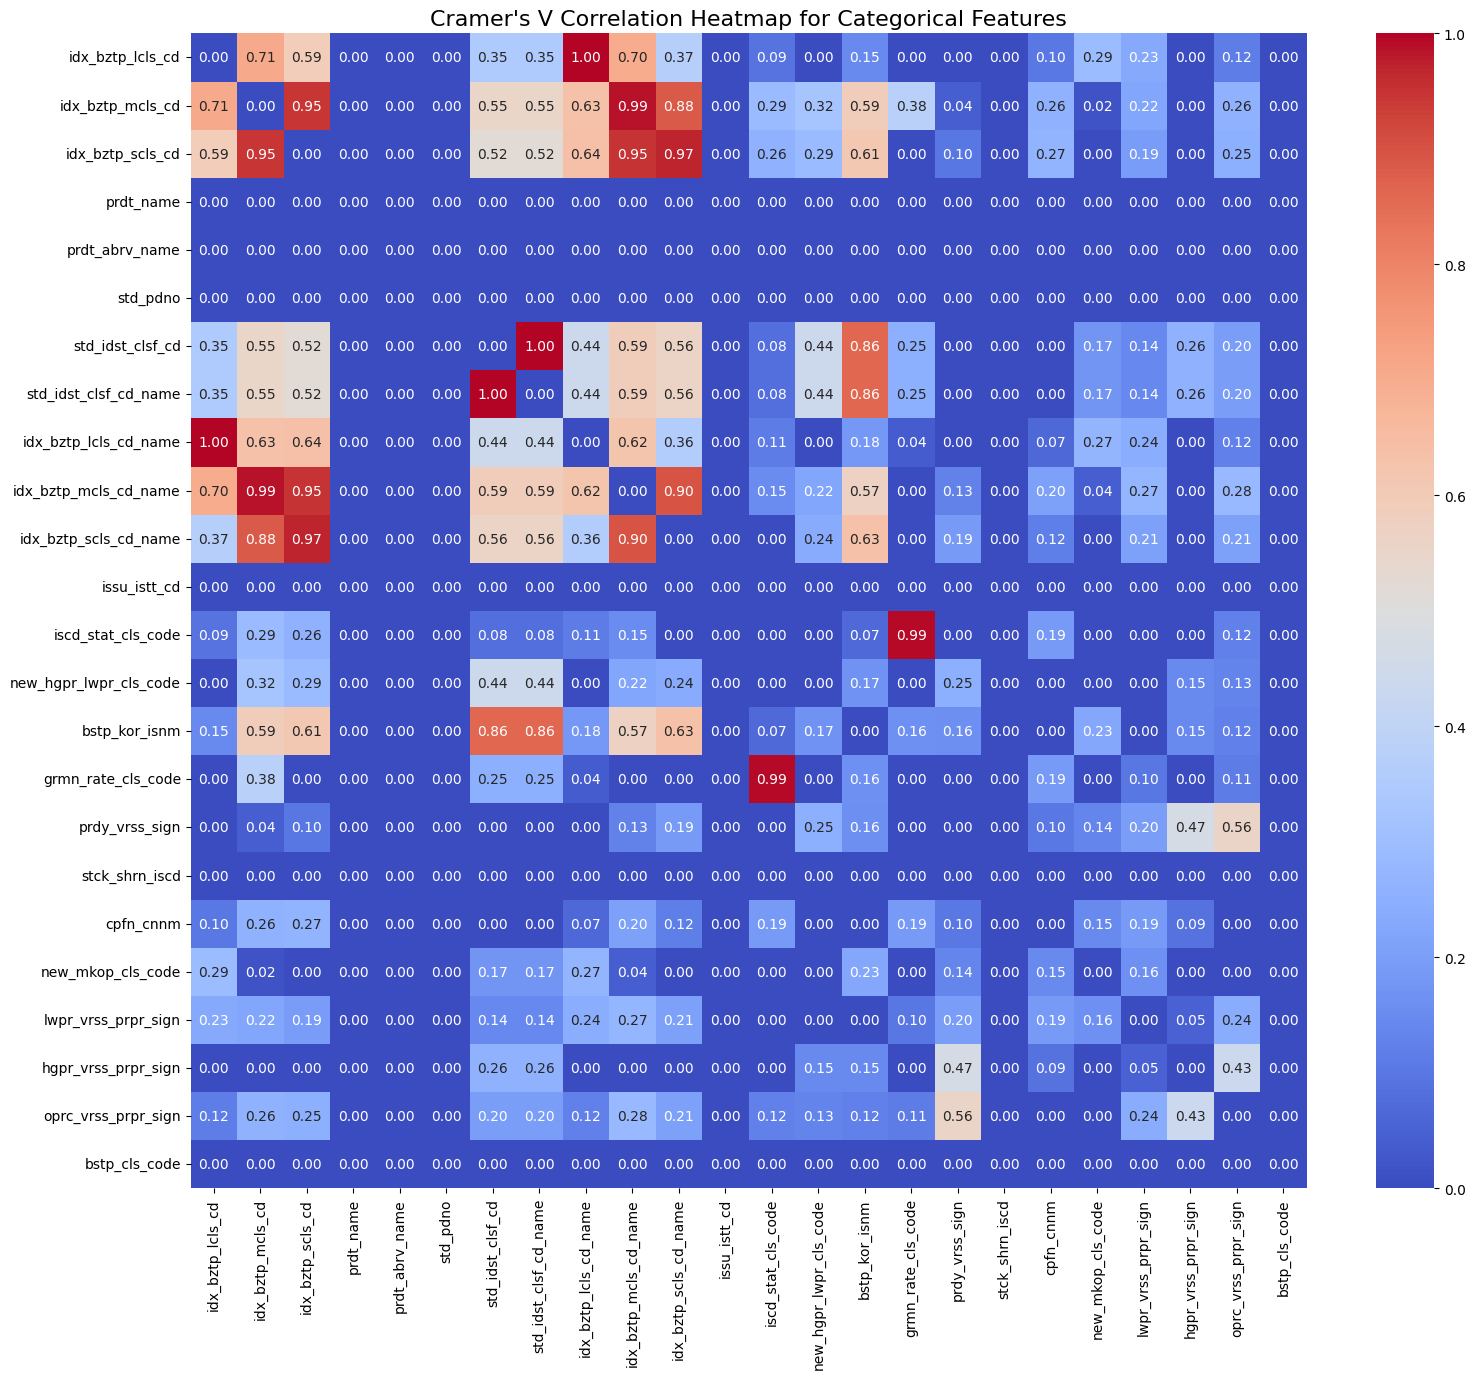


✅ 총 6개의 변수 쌍에서 임계값(0.95)을 초과하는 높은 연관성이 발견되었습니다.
----------------------------------------------------------------------
연관성이 높은 변수 쌍:
- std_idst_clsf_cd_name & std_idst_clsf_cd: 1.0000
- idx_bztp_lcls_cd_name & idx_bztp_lcls_cd: 0.9974
- grmn_rate_cls_code & iscd_stat_cls_code: 0.9949
- idx_bztp_mcls_cd_name & idx_bztp_mcls_cd: 0.9859
- idx_bztp_scls_cd_name & idx_bztp_scls_cd: 0.9691
- idx_bztp_mcls_cd_name & idx_bztp_scls_cd: 0.9501

👉 연관성이 높은 변수 리스트 (10개):
['idx_bztp_scls_cd', 'iscd_stat_cls_code', 'idx_bztp_lcls_cd', 'grmn_rate_cls_code', 'idx_bztp_lcls_cd_name', 'std_idst_clsf_cd', 'idx_bztp_mcls_cd', 'std_idst_clsf_cd_name', 'idx_bztp_mcls_cd_name', 'idx_bztp_scls_cd_name']

👉 연관성이 낮은 변수 리스트 (14개):
['prdt_name', 'prdt_abrv_name', 'std_pdno', 'issu_istt_cd', 'new_hgpr_lwpr_cls_code', 'bstp_kor_isnm', 'prdy_vrss_sign', 'stck_shrn_iscd', 'cpfn_cnnm', 'new_mkop_cls_code', 'lwpr_vrss_prpr_sign', 'hgpr_vrss_prpr_sign', 'oprc_vrss_prpr_sign', 'bstp_cls_code']


In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from itertools import combinations

categorical_df = df_cleaned[cleaned_categorical_cols].astype('str')

# --- Step 1: 크래머 V 계산을 위한 함수 정의 ---
def cramers_v(contingency_table):
  """ 두 범주형 변수 간의 크래머 V 계수를 계산합니다. """
  chi2 = chi2_contingency(contingency_table)[0]
  n = contingency_table.sum().sum()
  phi2 = chi2 / n
  r, k = contingency_table.shape
  phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
  r_corr = r - ((r-1)**2)/(n-1)
  k_corr = k - ((k-1)**2)/(n-1)
  if min((k_corr-1), (r_corr-1)) == 0:
    return 0
  else:
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# --- Step 2: 크래머 V 상관 행렬 계산 ---
cramers_v_matrix = pd.DataFrame(
  np.zeros((len(cleaned_categorical_cols), len(cleaned_categorical_cols))),
  index=cleaned_categorical_cols,
  columns=cleaned_categorical_cols
)

for col1, col2 in combinations(cleaned_categorical_cols, 2):
  contingency = pd.crosstab(categorical_df[col1], categorical_df[col2])
  v = cramers_v(contingency)
  cramers_v_matrix.loc[col1, col2] = v
  cramers_v_matrix.loc[col2, col1] = v

# --- Step 3: 히트맵 시각화 ---
plt.figure(figsize=(18, 15))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cramer\'s V Correlation Heatmap for Categorical Features', fontsize=16)
plt.show()

# --- Step 4: 연관성이 높은 변수 쌍 추출 ---
threshold = 0.95
str_high_corr_pairs = []

for i in range(len(cramers_v_matrix.columns)):
  for j in range(i):
    if cramers_v_matrix.iloc[i, j] > threshold:
      pair = (cramers_v_matrix.columns[i], cramers_v_matrix.columns[j], cramers_v_matrix.iloc[i, j])
      str_high_corr_pairs.append(pair)

str_high_corr_pairs.sort(key=lambda x: x[2], reverse=True)

print(f"\n✅ 총 {len(str_high_corr_pairs)}개의 변수 쌍에서 임계값({threshold})을 초과하는 높은 연관성이 발견되었습니다.")
print("-" * 70)
print("연관성이 높은 변수 쌍:")
for pair in str_high_corr_pairs:
  print(f"- {pair[0]} & {pair[1]}: {pair[2]:.4f}")

# --- Step 5: 연관성이 높은 변수와 낮은 변수 리스트 분리 ---

# 1. 연관성이 높은 변수들의 이름만 추출 (중복 제거를 위해 set 사용)
high_corr_cols_set = set()
for pair in str_high_corr_pairs:
  high_corr_cols_set.add(pair[0])
  high_corr_cols_set.add(pair[1])

high_corr_cols = list(high_corr_cols_set)

# 2. 전체 범주형 변수 중, high_corr_cols에 포함되지 않은 변수들만 선택
low_corr_cols = [col for col in cleaned_categorical_cols if col not in high_corr_cols]

# 3. 결과 확인
print("\n" + "="*70)
print(f"👉 연관성이 높은 변수 리스트 ({len(high_corr_cols)}개):")
print(high_corr_cols)
print("\n" + "="*70)
print(f"👉 연관성이 낮은 변수 리스트 ({len(low_corr_cols)}개):")
print(low_corr_cols)
print("="*70)

### 범주형 변수 그룹 분석 (임계값: 0.95)

| 변수명 | 한글명 | 선정여부 | 선정 근거 |
| :--- | :--- | :--- | :--- |
| `std_idst_clsf_cd_name` | 표준산업분류명 | **선정** | 코드보다 사람이 해석하기 용이한 '이름' 변수이며, 산업분류 정보의 핵심. |
| `std_idst_clsf_cd` | 표준산업분류코드 | 제거 | `std_idst_clsf_cd_name`이 동일한 정보를 제공하며, 해석이 더 용이함. |
| `idx_bztp_lcls_cd_name` | 업종 대분류명 | **선정** | 가장 상위 레벨의 업종 정보로, 거시적인 그룹 분석에 필요. |
| `idx_bztp_lcls_cd` | 업종 대분류코드 | 제거 | `idx_bztp_lcls_cd_name`이 동일한 정보를 제공하며, 해석이 더 용이함. |
| `idx_bztp_scls_cd_name` | 업종 소분류명 | **선정** | 가장 세분화된 업종 정보로, 정밀한 분석에 필요. |
| `idx_bztp_scls_cd` | 업종 소분류코드 | 제거 | `idx_bztp_scls_cd_name`이 동일한 정보를 제공하며, 해석이 더 용이함. |
| `idx_bztp_mcls_cd_name` | 업종 중분류명 | 제거 | `idx_bztp_scls_cd_name`과 연관성이 매우 높으며, 소분류가 더 세분화된 정보를 제공함. |
| `idx_bztp_mcls_cd` | 업종 중분류코드 | 제거 | `idx_bztp_scls_cd_name`이 더 세분화된 정보를 제공함. |
| `iscd_stat_cls_code` | 종목 상태 구분 코드 | **선정** | 관리종목 여부를 포함하는 더 포괄적이고 일반적인 종목 상태 정보. |
| `grmn_rate_cls_code` | 관리 종목 구분 코드 | 제거 | `iscd_stat_cls_code`와 연관성이 매우 높아 거의 동일한 상태 정보를 나타냄. |


In [16]:
selected_categorical_cols = low_corr_cols + [
  'std_idst_clsf_cd_name',
  'idx_bztp_lcls_cd_name',
  'idx_bztp_scls_cd_name',
  'iscd_stat_cls_code'
]
print(f"총 {len(selected_categorical_cols)}개의 범주형 변수가 최종 선정되었습니다.")

총 18개의 범주형 변수가 최종 선정되었습니다.


In [17]:
final_cols = selected_numeric_cols + selected_categorical_cols + cleaned_datetime_cols

print(f"final cols({len(final_cols)}) = numerical({len(selected_numeric_cols)}) + categorical({len(selected_categorical_cols)}) + datetime({len(cleaned_datetime_cols)})")

final cols(112) = numerical(87) + categorical(18) + datetime(7)


In [18]:
final_df = df[final_cols]
final_df

,prdy_vrss,prdy_ctrt,acml_tr_pbmn,prdy_vrss_vol_rate,hts_frgn_ehrt,frgn_ntby_qty,pgtr_ntby_qty,aspr_unit,hts_avls,per,pbr,vol_tnrt,eps,bps,d250_hgpr_vrss_prpr_rate,dryy_hgpr_vrss_prpr_rate,w52_hgpr_vrss_prpr_ctrt,whol_loan_rmnd_rate,last_ssts_cntg_qty,aspr_acpt_hour,askp_rsqn1,askp_rsqn2,askp_rsqn3,askp_rsqn4,askp_rsqn5,askp_rsqn6,askp_rsqn7,askp_rsqn8,askp_rsqn9,askp_rsqn10,bidp_rsqn1,bidp_rsqn2,bidp_rsqn3,bidp_rsqn4,bidp_rsqn5,bidp_rsqn6,bidp_rsqn7,bidp_rsqn8,bidp_rsqn9,bidp_rsqn10,total_askp_rsqn,total_bidp_rsqn,ntby_aspr_rsqn,prdy_clpr_vrss_oprc_rate,lwpr_vrss_prpr,prdy_clpr_vrss_lwpr_rate,hgpr_vrss_prpr,prdy_clpr_vrss_hgpr_rate,oprc_vrss_prpr,thdt_clpr,bfdy_clpr,stck_oprc,stck_hgpr,stck_lwpr,wghn_avrg_stck_prc,stck_mxpr,stck_llam,stck_sdpr,stck_sspr,sbst_pric,askp1,askp10,bidp1,bidp10,pvt_pont_val,pvt_frst_dmrs_prc,pvt_scnd_dmrs_prc,pvt_frst_dmsp_prc,pvt_scnd_dmsp_prc,dmrs_val,dmsp_val,stck_dryy_hgpr,lstg_stqt,acml_vol,prdy_vol,frgn_hldn_qty,w52_lwpr,d250_lwpr,stck_dryy_lwpr,w52_lwpr_vrss_prpr_ctrt,d250_lwpr_vrss_prpr_rate,dryy_lwpr_vrss_prpr_rate,papr,marg_rate,cpta,w52_hgpr,d250_hgpr,prdt_name,prdt_abrv_name,std_pdno,issu_istt_cd,new_hgpr_lwpr_cls_code,bstp_kor_isnm,prdy_vrss_sign,stck_shrn_iscd,cpfn_cnnm,new_mkop_cls_code,lwpr_vrss_prpr_sign,hgpr_vrss_prpr_sign,oprc_vrss_prpr_sign,bstp_cls_code,std_idst_clsf_cd_name,idx_bztp_lcls_cd_name,idx_bztp_scls_cd_name,iscd_stat_cls_code,scts_mket_lstg_dt,d250_hgpr_date,d250_lwpr_date,dryy_hgpr_date,dryy_lwpr_date,w52_hgpr_date,w52_lwpr_date
0,-800.0,-0.99,1672547819584,81.57,51.11,-537726.0,938828,100,4717951,16.10,1.38,0.35,4950.0,57930,-1.85,-1.85,-1.85,0.17,489779,160000,13017,169308,419352,114908,74080,110920,114116,182638,57278,75765,76986,368213,346156,230969,113667,134434,92375,134734,37943,39241,1331382,1574718,243336,0.75,100.0,-1.12,-1500.0,0.87,-1400.0,79700,79700,81100,81200,79600,80032.73,104600,56400,80500,61180,60570,79800,80700,79700,78800,79866,81132,81766,79232,77966,81450,79550,81200,5919637922,20898386,25619036,3025406868,49900,49900,50800,59.72,59.72,56.89,100,20.0,778046685000,81200,81200,삼성전자보통주,삼성전자,KR7005930003,00593,신고가,전기·전자,5,005930,"7,780 억",31,2,5,5,005930,통신 및 방송 장비 제조업,시가총액규모대,"전기,전자",55,1975-06-11,2025-09-19,2024-11-14,2025-09-19,2025-02-03,2025-09-19,2024-11-14
1,NaN,NaN,1546050743059,96.89,56.08,-982503.0,-357729,500,2569848,12.99,3.38,0.60,27182.0,104567,-1.94,-1.94,-1.94,0.16,84763,160000,24717,92990,113523,93498,21597,24558,11583,9984,5897,2980,1200,7851,8441,7159,5496,17659,16585,15733,16953,23271,401327,120348,-280979,-0.42,5000.0,-1.42,-7000.0,1.98,1500.0,353000,353000,351500,360000,348000,352559.79,458500,247500,353000,254160,254160,353000,357500,352500,348000,348833,361166,369333,340666,328333,365250,344750,360000,728002365,4385543,4526286,408260104,144700,144700,162700,143.95,143.95,116.96,5000,20.0,3657652050000,360000,360000,에스케이하이닉스보통주,SK하이닉스,KR7000660001,00066,신고가,전기·전자,3,000660,"36,576 억",31,2,5,2,000660,반도체 제조업,시가총액규모대,"전기,전자",55,1996-12-26,2025-09-19,2024-09-19,2025-09-19,2025-04-09,2025-09-19,2024-09-19
2,-5000.0,-1.41,64980756750,106.97,4.09,-23961.0,-36176,500,817830,-80.27,3.87,0.08,-4354.0,90240,-21.28,-13.28,-21.28,0.11,45469,160001,3341,1782,1416,2238,1483,1103,1689,608,514,940,665,1787,1168,3259,4444,2491,2129,1774,1772,237,15114,19726,4612,-0.85,2000.0,-1.97,-5000.0,NaN,-2000.0,349500,349500,351500,354500,347500,349535.95,460500,248500,354500,269420,265620,349500,354000,349000,344500,352000,357000,359500,349500,344500,358250,350750,403000,234000000,185906,173795,9580313,266000,266000,266000,31.39,31.39,31.39,500,20.0,117000000000,444000,444000,LG에너지솔루션보통주,LG에너지솔루션,KR7373220003,37322,NaN,전기·전자,5,373220,"1,170 억",31,2,5,5,373220,일차전지 및 축전지 제조업,None,None,55,2022-01-27,2024-10-08,2025-05-23,2025-07-31,2025-05-23,2024-10-08,2025-05-23
3,-5000.0,-0.49,93367438000,177.89,12.86,5913.0,7932,1000,728822,67.28,6.68,0.13,15221.0,153212,-15.30,-15.30,-15.30,0.09,1706,160001,333,252,652,496,328,1497,566,381,401,95,464,2015,3551,3610

In [19]:
import pandas as pd

# 보고서 전체 너비 설정
WIDTH = 80

print("=" * WIDTH)
print("EDA & Feature Selection Final Report".center(WIDTH))
print("=" * WIDTH)

# --- 1. 데이터 통합 요약 ---
print("\n" + "=" * WIDTH)
print("Step 1: Data Integration Summary".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Initial number of tables: {len(dataframes)}")
print(f"[INFO] Merged into a single DataFrame.")
print("-" * WIDTH)
print(f"[ACTION] Deduplicated features based on priority.")
total_dropped_count = 0
for name in priority_order:
  original_cols = len(dataframes[name].columns)
  dedup_cols = len(deduplicated_dataframes[name].columns)
  dropped_count = original_cols - dedup_cols
  total_dropped_count += dropped_count
  print(f"- {name:<15} : Selected {dedup_cols:>2} features, Dropped {dropped_count:>2} features")

print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Dropped features:".ljust(WIDTH - len(str(total_dropped_count))) + str(total_dropped_count))
print(f"[SUMMARY] Shape after initial merge :".ljust(WIDTH - len(str(df.shape))) + str(df.shape))

# --- 2. 데이터 품질 기반 피처 선택 요약 ---
print("\n" + "=" * WIDTH)
print("Step 2: Feature Selection based on Data Quality".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Initial DataFrame shape:".ljust(WIDTH - len(str(df.shape))) + str(df.shape))
print(f"[INFO] Thresholds:".ljust(WIDTH - len(f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%")) + f"Missing Percent > {MISSING_PERCENT_THRESHOLD:.1f}%")
print(f"[INFO] Thresholds:".ljust(WIDTH - len(f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}")) + f"Unique Count <= {UNIQUE_COUNT_THRESHOLD:>4}")
print("-" * WIDTH)
print("[ACTION] Dropping features...")
if drop_missing_cols:
  header_text = f" Reason: High Missing Value Ratio ({len(drop_missing_cols)} features) "
  print(f"\n{header_text.center(WIDTH, '-')}")
  for col, val in drop_missing_cols.items():
    left_str = f"- Dropping {col}"
    right_str = f"(Missing: {val:.2f}%)"
    print(left_str.ljust(WIDTH - len(right_str)) + right_str)
if drop_unique_cols:
  header_text = f" Reason: Low Unique Value Count ({len(drop_unique_cols)} features) "
  print(f"\n{header_text.center(WIDTH, '-')}")
  for col, val in drop_unique_cols.items():
    left_str = f"- Dropping {col}"
    right_str = f"(Unique Count: {int(val)})"
    print(left_str.ljust(WIDTH - len(right_str)) + right_str)
print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Dropped features:".ljust(WIDTH - len(str(len(total_drop_cols)))) + str(len(total_drop_cols)))
print(f"[SUMMARY] Cleaned DataFrame shape:".ljust(WIDTH - len(str(df_cleaned.shape))) + str(df_cleaned.shape))

# --- 3. 상관관계 기반 피처 선택 요약 (수치형) ---
print("\n" + "=" * WIDTH)
print("Step 3: Feature Selection based on Correlation (Numeric)".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Total numeric features:".ljust(WIDTH - len(str(len(cleaned_numeric_cols)))) + str(len(cleaned_numeric_cols)))
print(f"[INFO] Correlation Threshold:".ljust(WIDTH - 4) + str(THRESHHOLD))
print(f"[INFO] Found High Correlation pair:".ljust(WIDTH - len(str(len(num_high_corr_pairs)))) + str(len(num_high_corr_pairs)))
print(f"[INFO] Identified correlation clusters:".ljust(WIDTH - len(str(len(clusters)))) + str(len(clusters)))
print("-" * WIDTH)
print("[ACTION] Performing systematic feature selection for multicollinearity:")
print("  - Calculated the Pearson correlation matrix for all numeric pairs.")
print("  - Grouped highly correlated features (>0.95) into clusters.")
print("  - A network graph algorithm was used to identify these clusters.")
print("  - Manually reviewed each cluster to select a representative feature.")
print("  - Combined selected features with low-correlation features.")
print("\n" + "-" * WIDTH)
total_numeric_dropped = len(cleaned_numeric_cols) - len(selected_numeric_cols)
print(f"[SUMMARY] Selected numerical features:".ljust(WIDTH - len(str(len(selected_numeric_cols)))) + str(str(len(selected_numeric_cols))))
print(f"[SUMMARY] Dropped numerical features:".ljust(WIDTH - len(str(total_numeric_dropped))) + str(total_numeric_dropped))


# --- 4. 상관관계 기반 피처 선택 요약 (범주형) ---
print("\n" + "=" * WIDTH)
print("Step 4: Feature Selection based on Association (Categorical)".center(WIDTH))
print("=" * WIDTH)
print(f"[INFO] Total categorical features:".ljust(WIDTH - len(str(len(cleaned_categorical_cols)))) + str(len(cleaned_categorical_cols)))
print(f"[INFO] Cramer's V Threshold:".ljust(WIDTH - 4) + str(0.95))
print(f"[INFO] Found High Correlation pair:".ljust(WIDTH - len(str(len(str_high_corr_pairs)))) + str(len(str_high_corr_pairs)))
print("-" * WIDTH)
print("[ACTION] Performing systematic feature selection for redundancy:")
print("  - Calculated Cramer's V for all categorical feature pairs.")
print("  - Grouped highly associated features (>0.95) into clusters.")
print("  - Manually reviewed each cluster to select a representative feature.")
print("  - Combined selected features with low-association features.")
total_categorical_dropped = len(cleaned_categorical_cols) - len(selected_categorical_cols)
print("\n" + "-" * WIDTH)
print(f"[SUMMARY] Selected categorical features:".ljust(WIDTH - len(str(len(selected_categorical_cols)))) + str(str(len(selected_categorical_cols))))
print(f"[SUMMARY] Dropped categorical features:".ljust(WIDTH - len(str(total_categorical_dropped))) + str(total_categorical_dropped))


# --- 5. 최종 요약 ---
print("\n" + "=" * WIDTH)
print("Final Feature Set Summary".center(WIDTH))
print("=" * WIDTH)
final_numeric_count = len(selected_numeric_cols)
final_categorical_count = len(selected_categorical_cols)
final_total = final_numeric_count + final_categorical_count
print("[RESULT]")
print(f"  - Final DataFrame Shape:".ljust(WIDTH - len(str(final_df.shape))) + str(final_df.shape))
print(f"  - Numeric Features:".ljust(WIDTH - len(str(len(selected_numeric_cols)))) + str(len(selected_numeric_cols)))
print(f"  - Categorical Features:".ljust(WIDTH - len(str(len(selected_categorical_cols)))) + str(len(selected_categorical_cols)))
print(f"  - Datetime Features:".ljust(WIDTH - len(str(len(cleaned_datetime_cols)))) + str(len(cleaned_datetime_cols)))

print("=" * WIDTH)

                      EDA & Feature Selection Final Report                      

                        Step 1: Data Integration Summary                        
[INFO] Initial number of tables: 4
[INFO] Merged into a single DataFrame.
--------------------------------------------------------------------------------
[ACTION] Deduplicated features based on priority.
- df_basic_info   : Selected 21 features, Dropped  0 features
- df_price_basic  : Selected 68 features, Dropped  0 features
- df_asking_price : Selected 46 features, Dropped  0 features
- df_price_detail : Selected 14 features, Dropped 18 features

--------------------------------------------------------------------------------
[SUMMARY] Dropped features:                                                   18
[SUMMARY] Shape after initial merge :                                 (200, 146)

                Step 2: Feature Selection based on Data Quality                 
[INFO] Initial DataFrame shape:                           